# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline of the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found in. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#for math and padat structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose as sd

#for visualizations
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('zillow_data.csv')
display(df.head())
df.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
len(df.SizeRank.unique())

14723

In [4]:
df.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

# Step 2: Data Preprocessing

This step we deemed unnecessary as the function for reshaping simultaneously handles datetime conversion and dropping of NaNs.

In [5]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[0:], format='%Y-%m')

In [6]:
# # changing column headers to datetime format
# col_labels = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank']
# dates = df.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], axis=1)
# df_dates = get_datetimes(dates)
# for x in df_dates:
#     col_labels.append(x)
# df.columns = col_labels

# Step 3: Reshape from Wide to Long Format

In [7]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [8]:
dfm = melt_data(df)

In [9]:
display(dfm.head())
dfm.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Month         datetime64[ns]
MeanValue     float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


### Step 3b: Selecting a region for investigation

Region = Atlanta, Georgia

In [10]:
ATL = dfm[(dfm.Metro == 'Atlanta')
          & (dfm.CountyName.isin(['Fulton','Dekalb']))].copy()
ATL.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,1996-04-01,97100.0
254,70808,30022,Johns Creek,GA,Atlanta,Fulton,255,1996-04-01,206900.0
305,70791,30004,Milton,GA,Atlanta,Fulton,306,1996-04-01,184800.0
492,70839,30058,Lithonia,GA,Atlanta,Dekalb,493,1996-04-01,84600.0
557,70854,30075,Roswell,GA,Atlanta,Fulton,558,1996-04-01,189500.0


In [11]:
# Remove columns which are not helpful for data analysis
ATL.drop(['RegionID','City','State','Metro','CountyName','SizeRank'], axis=1, inplace=True)
ATL.reset_index(drop=True, inplace=True)
ATL.head()

,RegionName,Month,MeanValue
0,30331,1996-04-01,97100.0
1,30022,1996-04-01,206900.0
2,30004,1996-04-01,184800.0
3,30058,1996-04-01,84600.0
4,30075,1996-04-01,189500.0


In [12]:
# See if any zipcodes are lacking observations
print(len(ATL.RegionName.unique()))
ATL.RegionName.value_counts()

41


30329    265
30305    265
30005    265
30324    265
30316    265
30308    265
30268    265
30084    265
30076    265
30004    265
30327    265
30319    265
30087    265
30350    265
30342    265
30326    265
30294    265
30038    265
30030    265
30213    265
30309    265
30317    265
30307    265
30033    265
30009    265
30360    265
30328    265
30363    265
30341    265
30331    265
30291    265
30075    265
30338    265
30306    265
30058    265
30034    265
30002    265
30022    265
30079     58
30032     58
30288     52
Name: RegionName, dtype: int64

In [13]:
# Removing zip codes lacking 265 observations
ATL = ATL[~ATL.RegionName.isin([30079,30032,30288])]

# Step 4: EDA and Visualization

In [14]:
# font = {'weight':'bold', 'size': 14}
# matplotlib.rc('font', **font)
# NOTE: if visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [15]:
### WHY WON"T THIS CODE WORK!!!!

# for zipcode in atlanta.keys():
#     plt.figure(figsize=(15,4))
#     atlanta[zipcode].plot(title=zipcode)

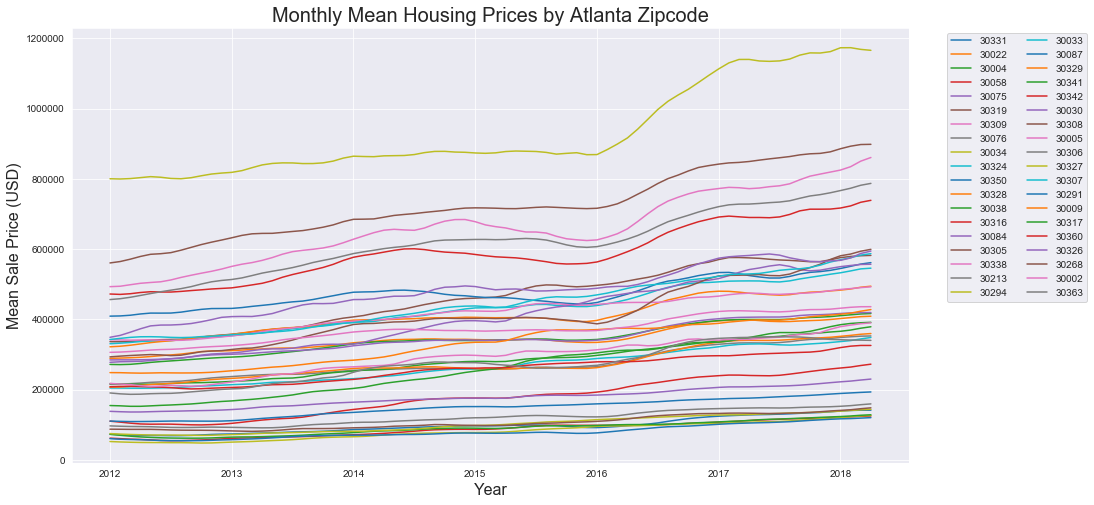

In [16]:
for zipcode in ATL.RegionName.unique():
    temp_df = ATL[(ATL.RegionName == zipcode)
                  & (ATL.Month >= '2012')].set_index('Month')
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)
plt.title("Monthly Mean Housing Prices by Atlanta Zipcode", fontsize=20);

Wonderful! It appears that each of the Atlanta zipcodes is capable of being plotted without throwing any errors.

#### Removing potentially confounding data

Looking at the graph above and thinking about recent history, we know that the housing crash of 2008 is the culprit behind the dip in housing price in the middle of our graph. Because we want to make business decisions based on post-crash trends. Therefore, we will build our models using only the data gathered after 2010 (2011-present) since this was when the housing market bottomed out. 

In [17]:
ATL2 = ATL[ATL.Month >='2012']

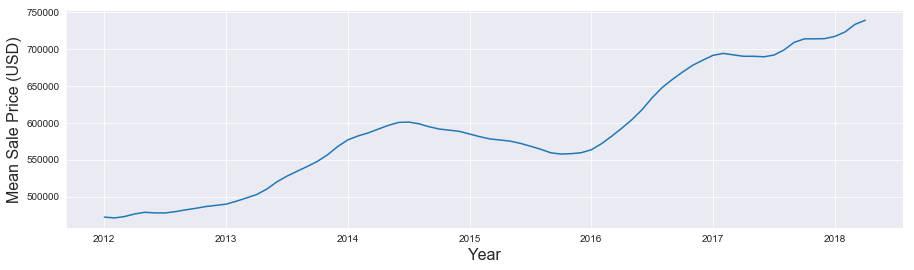

In [18]:
temp_df = ATL2[ATL2.RegionName == 30342].set_index('Month')
temp_df['MeanValue'].plot(figsize=(15,4), label=30342)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16);

# Step 5: ARIMA Modeling

Region: Atlanta

Best = Highest ROI with the lowest volatility since 2010 (after housing crash)

In [19]:
# Make a dictionary for each zipcode
atlanta = {}
for zipcode in ATL2.RegionName.unique():
    temp = ATL2[ATL2.RegionName == zipcode].set_index('Month')
    temp.drop('RegionName', axis=1, inplace=True)
    atlanta[zipcode] = temp

In [20]:
# Log transform the values
ATL_log ={}
for zipcode in atlanta.keys():
    ATL_log[zipcode] = np.log(atlanta[zipcode])

In [21]:
ATL_log_diff = {}
for key in list(atlanta.keys()):
    ATL_log_diff[key] = ATL_log[key].diff(periods=12).dropna()

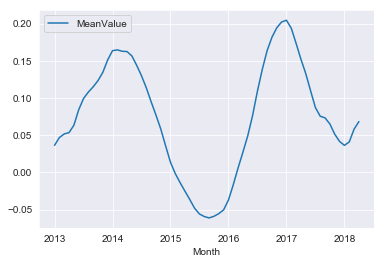

In [22]:
ATL_log_diff[30342].plot()

In [23]:
def stationarity_check(TS, column_name, rolling_window=7):    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = rolling_window, center = False).mean()
    rolstd = TS.rolling(window = rolling_window, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column_name]) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

In [24]:
def df_decompose(df):
    # Gather the trend, seasonality and noise of decomposed object
    trend = sd(df).trend
    seasonal = sd(df).seasonal
    residual = sd(df).resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.title(f"Decomposition for {df}")
    plt.subplot(411)
    plt.plot(df, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();
    
    return residual.dropna()

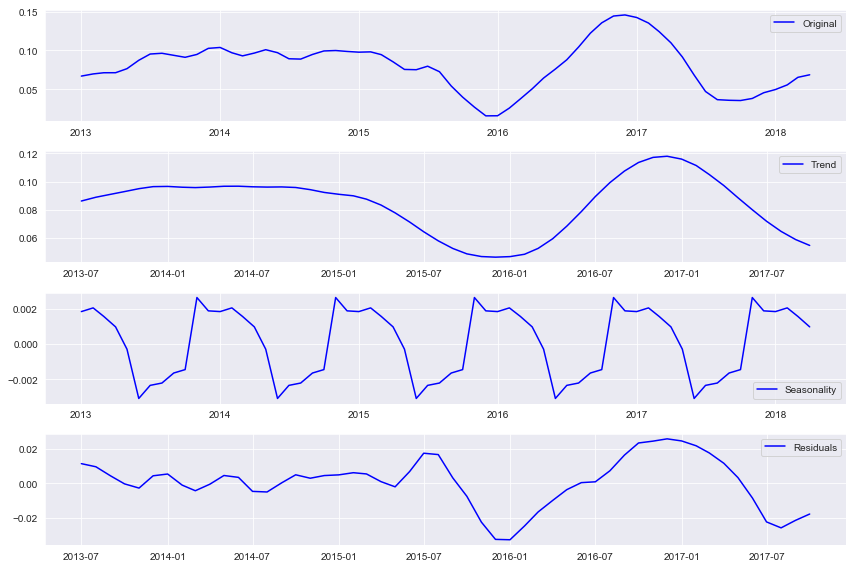

In [25]:
decomp30324 = df_decompose(ATL_log_diff[30324])

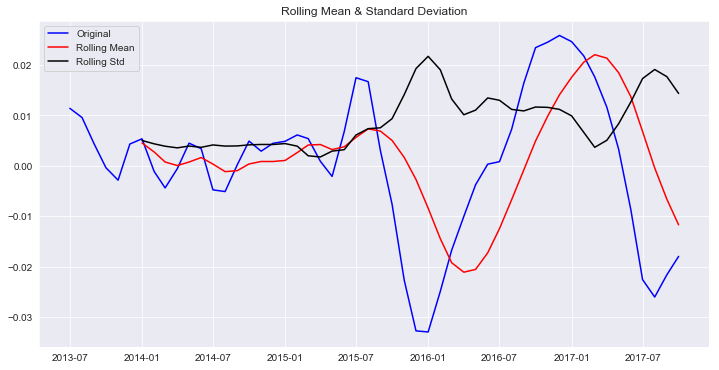

Results of Dickey-Fuller Test:
Test Statistic                 -3.785198
p-value                         0.003062
#Lags Used                      8.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [26]:
stationarity_check(decomp30324,'MeanValue')

In [27]:
# decompose data for each zipcode
    
for zipcode in ATL_log.keys()
    decomposition = sd(ATL_log[zipcode])
    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ATL_log[zipcode], label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();

SyntaxError: invalid syntax (<ipython-input-27-fbba4f038211>, line 3)

### Let's try using sARIMAX without seasonality

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

In [145]:
def find_best_pdq(df, label, pdq):
    """
    Input a dataframe and lists of potential pdq & pdqs values
    Finds combination of pdq/pdqs values that returns lowest AIC
    Returns tuple of label, pdq, and pdqs
    """
    results = []
    for params in pdq:
        try:
            model = SARIMAX(endog=df, order=params,
#                                 seasonal_order=seas_params,
                            enforce_stationarity=False, enforce_invertibility=False)
            AIC = model.fit().aic
#             print(f'ARIMA{params}x{seas_params}12 - AIC: {AIC}')
            results.append([params, AIC])
        except:
            continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
#     print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)
#     return results

In [30]:
pdq30342 = find_best_pdq(ATL_log[30342], 30342, pdq)

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No fre

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: 

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum L

Lowest AIC: ARIMA(2, 0, 1) - AIC: -637.6605880118941


C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [31]:
pdq30342

(30342, (2, 0, 1))

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:              MeanValue   No. Observations:                   76
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 322.830
Date:                Mon, 29 Jul 2019   AIC                           -637.661
Time:                        17:25:37   BIC                           -628.444
Sample:                    01-01-2012   HQIC                          -633.984
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8074      0.080     22.630      0.000       1.651       1.964
ar.L2         -0.8073      0.080    -10.103      0.000      -0.964      -0.651
ma.L1          0.5117      0.155      3.293      0.0

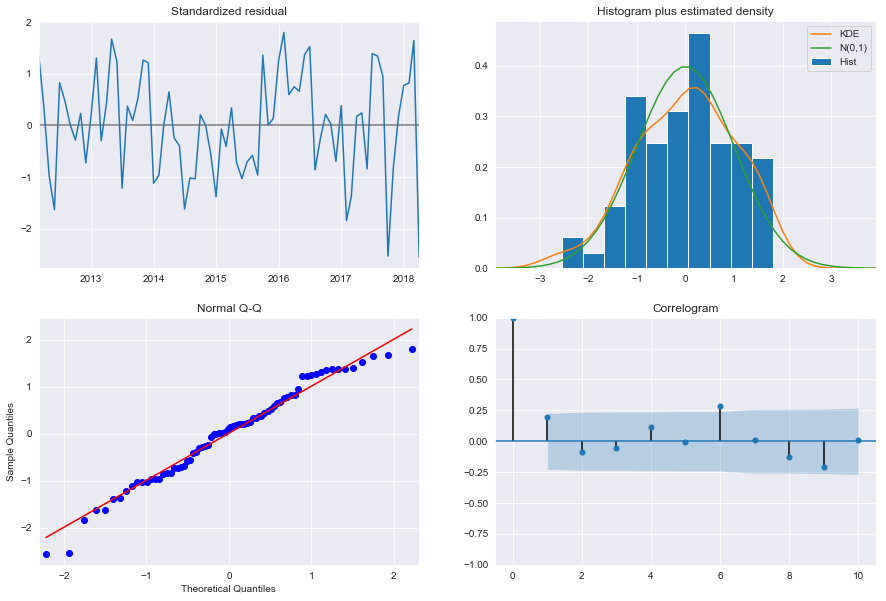

In [32]:
# plug the optimal parameter values into a new SARIMAX model.
mod_SARIMAX = SARIMAX(endog=ATL_log[30342], order=pdq30342[1],
                            enforce_stationarity=False, enforce_invertibility=False)

# Fit the model and print results
res_SARIMAX = mod_SARIMAX.fit()
print(res_SARIMAX.summary())
res_SARIMAX.plot_diagnostics(figsize=(15,10));

In [33]:
# Get predictions starting from 2016 and calculate confidence intervals.
prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
pred_conf = prediction.conf_int()

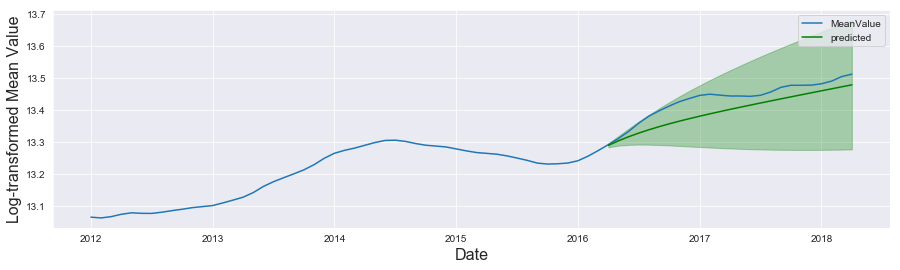

In [34]:
# Plot observed values
ATL_log[30342]['2012':].plot(label='observed')

# Plot predicted values
prediction.predicted_mean.plot(figsize=(15,4),color='g', label='predicted')

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

# Set axes labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Log-transformed Mean Value', fontsize=16)
plt.legend();

In [35]:
# Get the Real and predicted values
ATL30342_truth = ATL_log[30342]['2016-04':]
ATL30342_forecasted = prediction.predicted_mean

# Compute the mean square error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(ATL30342_truth, ATL30342_forecasted))
print(f'The Root Mean Squared Error of our forecasts is {round(rmse, 3)}')

The Root Mean Squared Error of our forecasts is 0.04


#### Now iterate through all selected zipcodes

In [146]:
def plot_predictions(df, label, prediction, pred_conf, result_pdq):
    # Plot observed values
    np.exp(df['2012':]).plot(label='observed')
    
    # Plot predicted values
    pred_price = np.exp(prediction.predicted_mean)
    pred_price.plot(figsize=(15,4),color='g', label='predicted')
    
    # Plot the range for confidence intervals
    pred_conf_usd = np.exp(pred_conf)
    plt.fill_between(pred_conf_usd.index,
                    pred_conf_usd.iloc[:, 0],
                    pred_conf_usd.iloc[:, 1], color='g', alpha=.3)
    
    # Set axes labels
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.title(f"{label} Zipcode; pdq={result_pdq[1]}", fontsize=16)
    plt.legend(loc='best')
    plt.show();


def expected_roi(df_forecasted):
    roi = ((df_forecasted[-1] - df_forecasted[0]) / df_forecasted[0])
    return roi


def confidence_score(pred_conf):
    pred_conf_usd = np.exp(pred_conf)
    conf_score = 1- ((pred_conf_usd['upper MeanValue'][-1]
                      - pred_conf_usd['lower MeanValue'][-1])
                     / pred_conf_usd['upper MeanValue'][-1])
    return conf_score


def make_best_Arima_model(df, label, pdq):
    import warnings
    warnings.filterwarnings('ignore')
    
    result_pdq = find_best_pdq(df, label, pdq)
    
    # plug the optimal parameter values into a new SARIMAX model.
    mod_SARIMAX = SARIMAX(endog=df, order=result_pdq[1],
                                enforce_stationarity=False, enforce_invertibility=False)
    
    # Fit the model and print results
    res_SARIMAX = mod_SARIMAX.fit()
#     print(res_SARIMAX.summary())
#     res_SARIMAX.plot_diagnostics(figsize=(15,10));
    
    # Get predictions starting from 2016 and calculate confidence intervals.
    prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
    pred_conf = prediction.conf_int()
    rmse = 0
    roi = 0
    conf_score = 0
    if pred_conf['lower MeanValue'][-1] > pred_conf['lower MeanValue'][0]:
        print("\n\nZipcode:", label)
        
        # Get the Real and predicted values
        df_truth = np.exp(df['2016-04':])
        df_forecasted = np.exp(prediction.predicted_mean)
        
        # Compute the mean square error & volatility
        rmse = np.sqrt(mean_squared_error(df_truth, df_forecasted))
        print(f'Root Mean Squared Error of forecast: {round(rmse, 3)}')
        conf_score = np.round(confidence_score(pred_conf), 4)
        print(f'Model confidence score: {conf_score}')
        
        #Expected 2-year return on investment
        roi = np.round(expected_roi(df_forecasted),4)
        print(f"Model 2-yr expected ROI rate: {roi*100}%")
        
        # Plot observed & predicted values with confidence interval
        plot_predictions(df, label, prediction, pred_conf, result_pdq);
    
    return result_pdq[1], res_SARIMAX, prediction.predicted_mean, pred_conf, rmse, roi, conf_score



Zipcode: 30004
Root Mean Squared Error of forecast: 8838.528
Model confidence score: 0.7923
Model 2-yr expected ROI rate: 17.53%


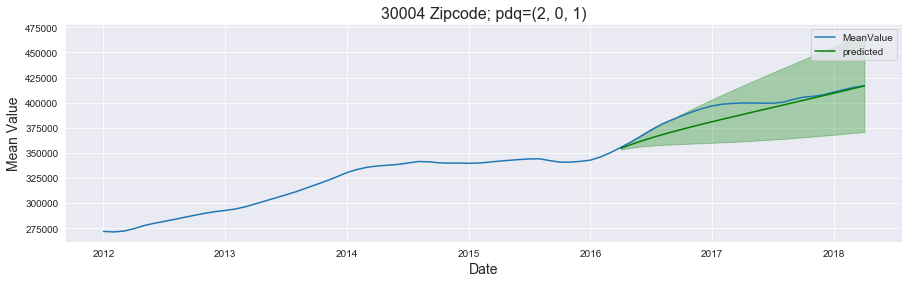



Zipcode: 30058
Root Mean Squared Error of forecast: 930.948
Model confidence score: 0.6549
Model 2-yr expected ROI rate: 26.900000000000002%


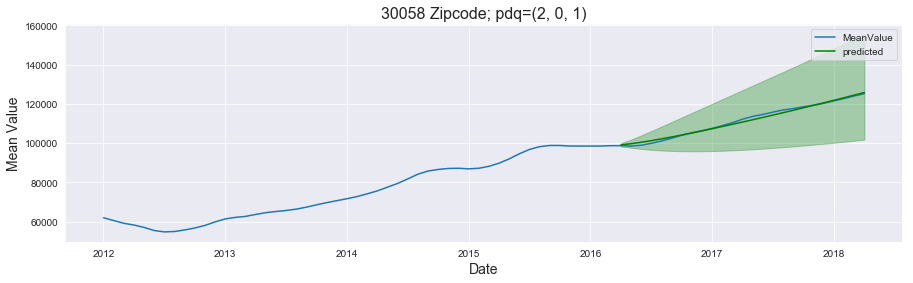



Zipcode: 30319
Root Mean Squared Error of forecast: 17569.948
Model confidence score: 0.8472
Model 2-yr expected ROI rate: 19.34%


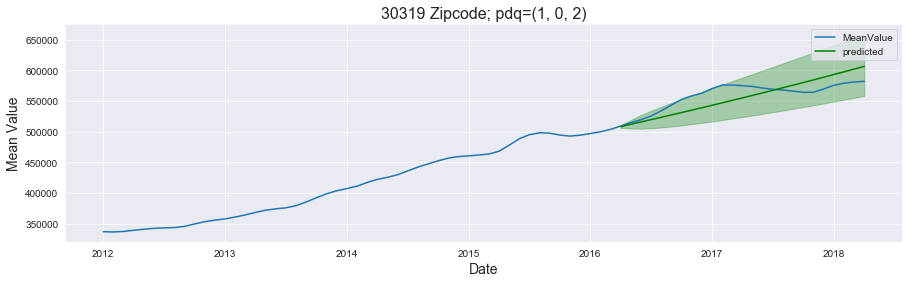



Zipcode: 30076
Root Mean Squared Error of forecast: 17941.142
Model confidence score: 0.7161
Model 2-yr expected ROI rate: 21.04%


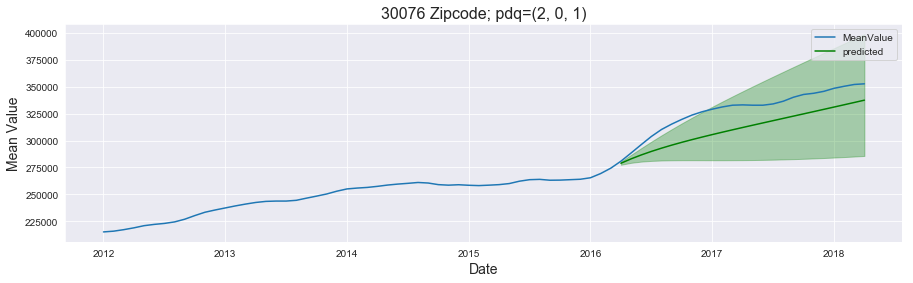



Zipcode: 30034
Root Mean Squared Error of forecast: 3660.55
Model confidence score: 0.6137
Model 2-yr expected ROI rate: 34.35%


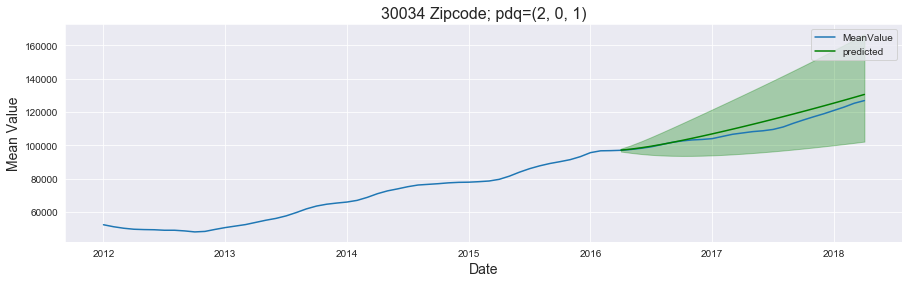



Zipcode: 30324
Root Mean Squared Error of forecast: 15807.595
Model confidence score: 0.8112
Model 2-yr expected ROI rate: 17.29%


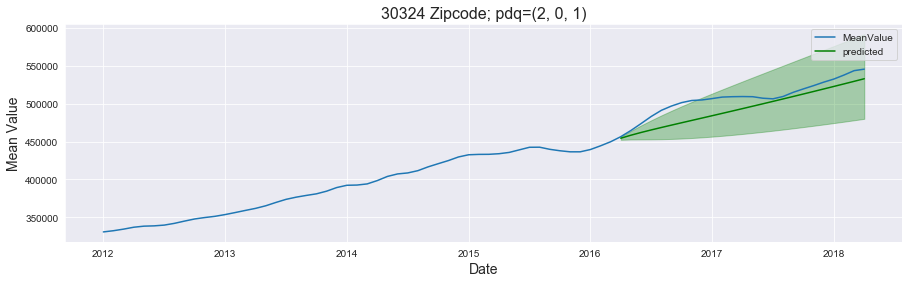



Zipcode: 30038
Root Mean Squared Error of forecast: 1540.85
Model confidence score: 0.697
Model 2-yr expected ROI rate: 25.180000000000003%


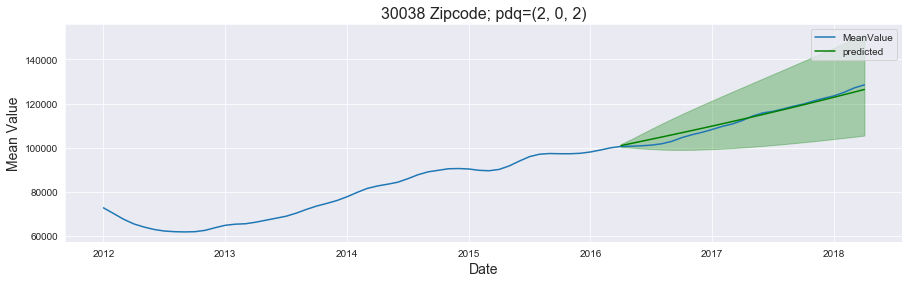



Zipcode: 30316
Root Mean Squared Error of forecast: 14703.595
Model confidence score: 0.6269
Model 2-yr expected ROI rate: 43.05%


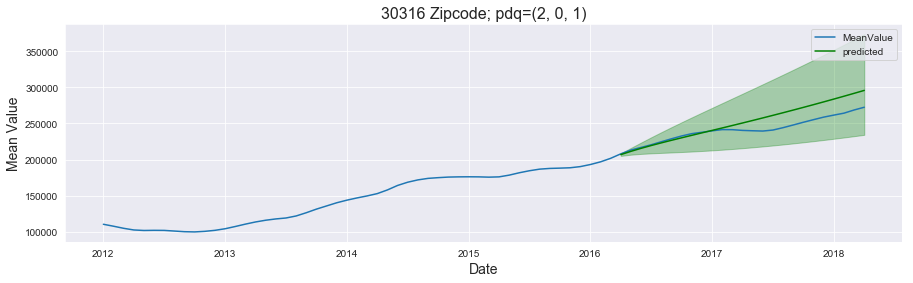



Zipcode: 30084
Root Mean Squared Error of forecast: 3680.07
Model confidence score: 0.8427
Model 2-yr expected ROI rate: 18.82%


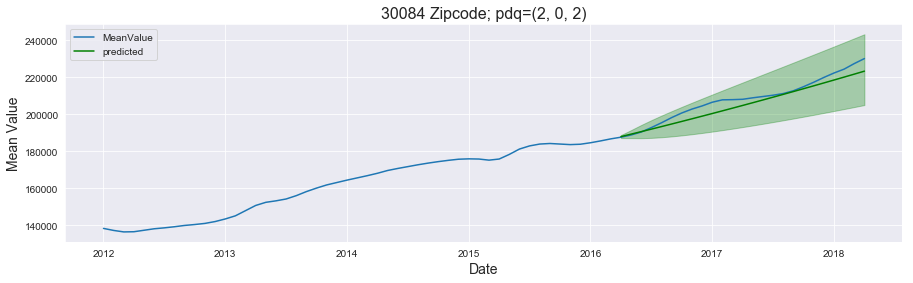

In [147]:
ATL_arima_models = []
for zipcode in list(ATL_log.keys())[:15]:
    model = make_best_Arima_model(ATL_log[zipcode], zipcode, pdq)
    ATL_arima_models.append([zipcode, model])

In [ ]:
break

### Let's try sARIMAX with seasonality

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal 
# p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

In [ ]:
def find_best_pdqs(df, label, pdq, pdqs):
    """
    Input a dataframe and lists of potential pdq & pdqs values
    Finds combination of pdq/pdqs values that returns lowest AIC
    Returns tuple of label, pdq, and pdqs
    """
    results = []
    for params in pdq:
        for seas_params in pdqs:
            try:
                model = SARIMAX(endog=df, order=params, seasonal_order=seas_params,
                                enforce_stationarity=False, enforce_invertibility=False)
                AIC = model.fit().aic
    #             print(f'ARIMA{params}x{seas_params}12 - AIC: {AIC}')
                results.append([params, seas_params, AIC])
            except:
                continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
    result_PDQs = results[0][1]
    print(f'Lowest AIC: ARIMA{result_pdq}x{result_PDQs} - AIC: {results[0][2]}')
    return (label, result_pdq, result_PDQs)

In [ ]:
pdqs30342 = find_best_pdqs(ATL_log[30342], 30342, pdq, pdqs)

In [ ]:
# plug the optimal parameter values into a new SARIMAX model.
mod_SARIMAX = SARIMAX(endog=ATL_log[30342], order=pdqs30342[1], seasonal_order=pdqs30342[2],
                            enforce_stationarity=False, enforce_invertibility=False)

# Fit the model and print results
res_SARIMAX = mod_SARIMAX.fit()
print(res_SARIMAX.summary())

In [ ]:
res_SARIMAX.plot_diagnostics(figsize=(15,10));

In [ ]:
# Get predictions starting from 2016 and calculate confidence intervals.
prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-01'), dynamic=True)
pred_conf = prediction.conf_int()

In [ ]:
# Plot observed values
ATL_log[30342]['2012':].plot(label='observed')

# Plot predicted values
prediction.predicted_mean.plot(figsize=(15,6),color='g', label='predicted')

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

# Set axes labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mean Value', fontsize=16)
plt.legend();

In [ ]:
# Get the Real and predicted values
ATL30342_truth = atlanta[30342]['2016-01':]
ATL30342_forecasted = prediction.predicted_mean

# Compute the mean square error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(ATL30342_truth, ATL30342_forecasted))
print(f'The Mean Squared Error of our forecasts is {round(rmse, 3)}')

# Step 6: Interpreting Results